# Project Overview

__Churn Prediction ML Modeling Using Apache Spark/PySpark on Sparkify Dataset__

This project aims to build a customer churn prediction model for the hypothetical music streaming service company Sparkify using the PySpark framework.

This workspace contains the exploratory data analysis, feature engineering, and modeling on a tiny subset (128MB) of the full dataset available (12GB). The most suitable model and hyper-parameters derived from the analysis on the tiny dataset will then be deployed to AWS for training the model on the full dataset.

# Import Libraries

In [394]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.sql.functions import asc, col, datediff, dayofmonth, desc, from_unixtime
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import udf
from pyspark.sql.types import DateType, IntegerType, StringType,DecimalType, DoubleType


%matplotlib inline
plt.style.use('seaborn-darkgrid')
sns.set(style="darkgrid")

# Create Spark Session and Load Data

In [400]:
# create spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()
spark.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1592857501613'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', 'mint.lan'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.port', '33949')]

In [401]:
# load data
file_path = "./mini_sparkify_event_data.json"
df = spark.read.json(file_path)

# Data Preprocessing 

In this section, we will take a high level look at the dataset and perform necessary data cleaning to prepare the data for further exploratory analysis.

## Size

In [402]:
print(f"The data set contains {df.count()} rows and {len(df.columns)} columns of data")

The data set contains 286500 rows and 18 columns of data


## Columns

In [403]:
# display columns names
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



## Descriptive Stats

In [407]:
df.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|           228108|    286500|   278154|278154|            286500|  278154|            228108|286500|           278154|286500| 286500|         

## Null Values

In [408]:
# check null values
for col in df.columns:
    print(col, "\t", "with null values:", df.filter(df[col].isNull()).count())

artist 	 with null values: 58392
auth 	 with null values: 0
firstName 	 with null values: 8346
gender 	 with null values: 8346
itemInSession 	 with null values: 0
lastName 	 with null values: 8346
length 	 with null values: 58392
level 	 with null values: 0
location 	 with null values: 8346
method 	 with null values: 0
page 	 with null values: 0
registration 	 with null values: 8346
sessionId 	 with null values: 0
song 	 with null values: 58392
status 	 with null values: 0
ts 	 with null values: 0
userAgent 	 with null values: 8346
userId 	 with null values: 0


## Exam columns with Null Values

In [9]:
# null values due to empty userId
df.select("userId","firstName","lastName", "location", "registration", "userAgent").where(F.col("firstName").isNull()).show()

+------+---------+--------+--------+------------+---------+
|userId|firstName|lastName|location|registration|userAgent|
+------+---------+--------+--------+------------+---------+
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|    

__Observation__

The null values in the `firstName`, `lastName`, `location`, `registration`, and `userAgent` columns correspond to `userId` of empty strings. We can assume that these event records are belong to non-registered users. Thus, these rows should be removed from the analysis.

In [10]:
# null values due to activities (page visited) not related to song playing 
df.select("userId", "page","artist","length", "song").where(F.col("artist").isNull()).show()

+------+---------------+------+------+----+
|userId|           page|artist|length|song|
+------+---------------+------+------+----+
|    30|Add to Playlist|  null|  null|null|
|     9|    Roll Advert|  null|  null|null|
|     9|      Thumbs Up|  null|  null|null|
|    54|      Downgrade|  null|  null|null|
|    54|      Thumbs Up|  null|  null|null|
|     9|    Thumbs Down|  null|  null|null|
|     9|           Home|  null|  null|null|
|     9|         Logout|  null|  null|null|
|    74|      Thumbs Up|  null|  null|null|
|      |           Home|  null|  null|null|
|      |           Help|  null|  null|null|
|      |           Home|  null|  null|null|
|      |          Login|  null|  null|null|
|     9|           Home|  null|  null|null|
|    30|    Thumbs Down|  null|  null|null|
|     4|         Logout|  null|  null|null|
|      |           Home|  null|  null|null|
|      |          Login|  null|  null|null|
|     4|           Home|  null|  null|null|
|    74|Add to Playlist|  null| 

The null values in the `artist`, `length` and `song` columns corresponds to actions not related to playing a song and corresponding rows should be kept for the analysis

## Clean Data

In [11]:
# exam and make sure we have valid userId for all records
df.select("userId").distinct().sort(asc("userId")).show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [12]:
# remove data where userID is empty string
df = df.filter("userId != ''")

In [410]:
# shape of cleaned data
print(f"After removing the data with empty string in the userId column, remaining data for further analysis contains {df.count()} rows and {len(df.columns)} columns of data")

After removing the data with empty string in the userId column, remaining data for further analysis contains 286500 rows and 18 columns of data


# Exploratory Data Analysis

## Data Overview

Categorize each into categorical vs. numerical. And get a high level understanding on what the date in each column represents

In [424]:
numerical_cols = []
categorical_cols = []

for col in df.schema:
    data_type = str(col.dataType)
    if data_type == "StringType":
        categorical_cols.append(col.name)
    if data_type == "LongType" or data_type == "DoubleType":
        numerical_cols.append(col.name)

In [433]:
# Look at 10 distinctive values in each of the categorical columns.
for col in categorical_cols:
    print("*"*80)
    print(f"distinct value counts: {df.select(col).distinct().count()}")
    df.select(col).distinct().show(10, truncate=False)

In [448]:
# Look at 10 unique values and descriptive stats for each numerical column
for col in numerical_cols:
    print("*"*80)
    print(f"number of distinct values: {df.select(col).distinct().count()}")
    print(f"number of null values: {df.filter(df[col].isNull()).count()}")
    df.select(col).distinct().show(10)
    df.select(col).describe().show(truncate=False)

********************************************************************************
number of distinct values: 1322
number of null values: 0
+-------------+
|itemInSession|
+-------------+
|           26|
|           29|
|          474|
|          964|
|           65|
|          191|
|          418|
|          541|
|          558|
|         1010|
+-------------+
only showing top 10 rows

+-------+------------------+
|summary|itemInSession     |
+-------+------------------+
|count  |286500            |
|mean   |114.41421291448516|
|stddev |129.76726201141108|
|min    |0                 |
|max    |1321              |
+-------+------------------+

********************************************************************************
number of distinct values: 14866
number of null values: 58392
+---------+
|   length|
+---------+
|200.75057|
|317.30893|
|260.28363|
|241.94567|
|262.79138|
|216.47628|
|361.66485|
|231.94077|
|375.03955|
|213.75955|
+---------+
only showing top 10 rows

+-------+----

__Observation__

Initial examination on the dataframe gives us a high level grasps on what kind of information each column represents:

- `artist`: Artist of the song. Null if the `page` column is not not song/music related
- `auth`: Authentication status: `Logged Out`, `Cancelled`, `Guest`, `Logged In`
- `userId`,`firstName`, `lastName`, `gender`, `location`: identification and information related to each unique user
- `method`:
    - `PUT` corresponds to user activities related to send data to server. For examples:`Logout`, `Save Settings`, `Add to Playlist` and etc
    - `GET` corresponds to user activities related to request data from server. For examples: `Downgrade`, `Error`, `Upgrade`, `Home`, and etc
- `itemInSession`: the sequential order of user actions/activities/page visited in each unique session 
- `length`: length of each song is played. Null if the `page` column is not `NextSong`
- `level`: account level - `free` or `paid`
- `page`: different website/app features that a user used/visited in each session
- `song`: song name
- `status`: HTTP status code.
    - 307:Tells the client to look at (browse to) another URL 
    - 404:Requested resource could not be found 
    - 200:OK. Standard response for successful HTTP requests
- `ts`: Unix timestamp for each event logged
- `userAgent`: the operating system and browser version for each user

##  Define Churn

In [442]:
# list of events in page column
df.select("page").distinct().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



We define a user is a `churned` user if the associated `userId` has `Cancellation Confirmation` event in the `page` column.

In [444]:
def get_churn(df=df):
    """
    Generate and returns a spark dataframe containing the userId and churn columns.
    A value of 1 in the churn column indicates the corresponding userId of a churned user
    A value of 0 in the churn column indicates the corresponding userId of an active user
    """
    
    
    df.createOrReplaceTempView("df")
    # query a table with churned userId and value 1 indicating they are churned user
    churned_userId = spark.sql(
        'SELECT DISTINCT userId, 1 as churn FROM df \
    WHERE page = "Cancellation Confirmation"'
    )
    # query a table with churned userId and value 0 indicating they are churned user
    unchurned_userId = spark.sql(
        'SELECT DISTINCT userId, 0 as churn FROM df \
    WHERE userId NOT IN (SELECT DISTINCT userId from df WHERE Page = "Cancellation Confirmation")'
    )
    
    # merge two table together
    return churned_userId.union(unchurned_userId)

__Plot Churn Count__

In [16]:
# Data preparation
churn_df = get_churn(df)
data = churn_df.toPandas()
counts = data["churn"].value_counts()
total = len(data)
labels = ["Active", "Churned"]

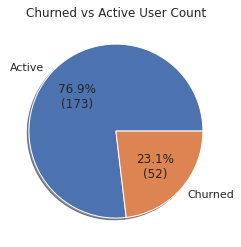

In [447]:
def my_fmt(x):
    """autopct formatter to display both actual value and percentage in pie chart"""
    return '{:.1f}%\n({:.0f})'.format(x, total*x/100)
                                      
# Draw Plot
plt.pie(counts, labels = labels, autopct = my_fmt, shadow=True)
plt.title("Churned vs Active User Count")
plt.savefig("./plots/churn_count.png")
plt.show()

## User Life Time 

The `life time` of a user is defined as the number of days past since a user's registration time and the last time a user's activity was logged.

In [18]:
def get_days_since_reg(df=df):
    """
    Returns the number of days since registration for each user
    """

    time_df = df.groupby("userId").agg(
        F.expr("from_unixtime(min(registration)/1000)").alias("reg_time"),
        F.expr("from_unixtime(max(ts)/1000)").alias("last_active_time"),
    )

    return time_df.withColumn(
        "days_since_reg", F.datediff(F.col("last_active_time"), F.col("reg_time"))
    ).select("userId", "days_since_reg")

In [19]:
# Data Preparation
life_df= get_days_since_reg(df)
data = life_df.join(churn_df, on=['userId']).toPandas()

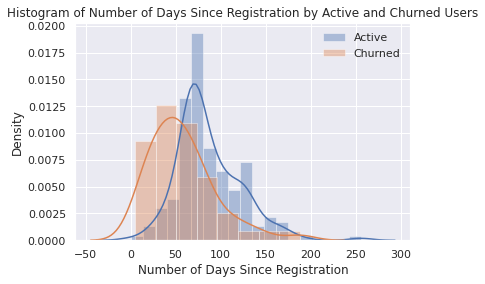

In [20]:
# Plot
sns.distplot(data[data["churn"] ==0]["days_since_reg"], kde =True, label = "Active")
sns.distplot(data[data["churn"] ==1]["days_since_reg"], kde =True, label = "Churned")
plt.xlabel("Number of Days Since Registration")
plt.ylabel("Density")
plt.title("Histogram of Number of Days Since Registration by Active and Churned Users")
plt.legend();

**Observation**

Churned users have shorter `life time` compared to that of the active users.

## Recent Inactive Days

The `recent inactive days` is defined as the time(# of days) difference between the latest time stamp data the data set and the latest logged time stamp for each user.  

In [365]:
def get_inactive_days(df=df):
    temp_df = df.groupby("userId").agg(
        F.expr("from_unixtime(max(ts)/1000)").alias("user_max_ts")
    )
    temp_df.createOrReplaceTempView("temp_df")
    temp_df = spark.sql(
        "SELECT userID, user_max_ts, \
            (SELECT MAX(user_max_ts) FROM temp_df) AS global_max_ts\
                FROM temp_df"
    )
    return temp_df.withColumn(
        "days_since_active", F.datediff(F.col("global_max_ts"), F.col("user_max_ts"))
    ).select("userId", "days_since_active")

In [376]:
inactive_df = get_inactive_days(df)
inactive_pd_df = churn_df.join(inactive_df, on=["userId"],how="left").na.fill(0).toPandas()
inactive_pd_df.iloc[:,1:].groupby("churn").describe()

days_since_active                                                   
                  count       mean        std  min   25%   50%   75%   max
churn                                                                     
0                 173.0   8.329480  10.018651  0.0   2.0   5.0  10.0  59.0
1                  52.0  36.288462  16.277419  3.0  23.0  40.0  48.5  62.0

In [378]:
inactive_pd_df

,userId,churn,days_since_active
0,100010,0,11
1,200002,0,17
2,125,1,52
3,124,0,2
4,51,1,46
...,...,...,...
220,45,0,4
221,57,0,13
222,200021,1,31
223,119,0,7


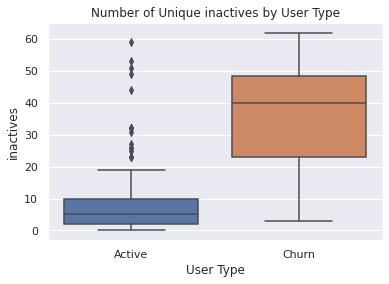

In [379]:
inactive_pd_df['churn'] =inactive_pd_df['churn'].map({0:"Active", 1:"Churn"})

ax = sns.boxplot(x="churn",y="days_since_active", data=inactive_pd_df)
ax.set_title("Number of Unique inactives by User Type")
ax.set_xlabel("User Type")
ax.set_ylabel("inactives");

## Number of Unique Sessions

Count the number of unique sessions logged by each user

In [21]:
def get_session_count(df=df):
    """Returns the count of distinct sessionId for each user """
    session_df = df.groupby("userId").agg(F.expr("count(distinct(sessionId))").alias("num_unique_sessions"))
    return session_df

In [22]:
session_df = get_session_count(df)
# Join the the session count with the churn df
session_pd_df = churn_df.join(session_df,on=["userId"], how = "left").na.fill(0).toPandas()
# Stats/distribution of unique session counts by user type
session_pd_df.iloc[:,1:].groupby("churn").describe()

num_unique_sessions                                                   
                    count       mean        std  min  25%   50%   75%    max
churn                                                                       
0                   173.0  15.254335  15.866963  1.0  6.0  11.0  19.0  107.0
1                    52.0  10.326923   8.610803  1.0  5.0   8.5  12.0   37.0

In [373]:
session_pd_df

,userId,churn,num_unique_sessions
0,100010,Active,7
1,200002,Active,6
2,125,Churn,1
3,124,Active,29
4,51,Churn,10
...,...,...,...
220,45,Active,16
221,57,Active,2
222,200021,Churn,17
223,119,Active,6


Plot the distribution

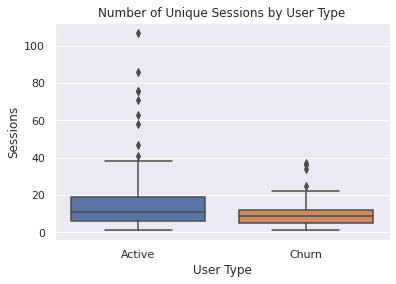

In [23]:
session_pd_df['churn'] =session_pd_df['churn'].map({0:"Active", 1:"Churn"})

ax = sns.boxplot(x="churn",y="num_unique_sessions", data=session_pd_df)
ax.set_title("Number of Unique Sessions by User Type")
ax.set_xlabel("User Type")
ax.set_ylabel("Sessions");

## User Gender

In [24]:
def get_gender(df = df):
    """
    Query and return the gender of each user
    """ 
    
    gender_df = df.groupby("userId").agg(Fmax("gender").alias('gender'))
    
    return gender_df

Text(0, 0.5, 'Count')

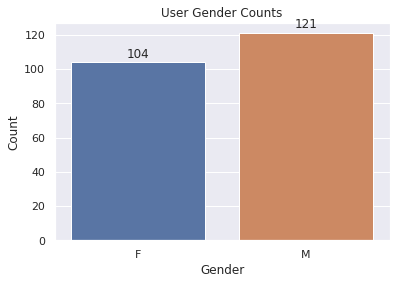

In [25]:
# create gender by userId dataframe
gender_df=get_gender(df)
# create gender counts df
data = gender_df.groupby("gender").agg(F.expr("count(userId)").alias("count")).toPandas()

# Plot gender counts df
ax = sns.barplot(x = "gender", y = "count", data = data)
# Annotations
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.0,
        height + 3,
        "{:.0f}".format(height),
        ha="center",
    )
plt.title("User Gender Counts")
plt.xlabel("Gender")
plt.ylabel("Count")

User Gender by Churn

In [26]:
data = gender_df.join(churn_df, on=["userId"]).toPandas()
data['churn'] = data['churn'].map({0:"Active", 1:"Churn"})

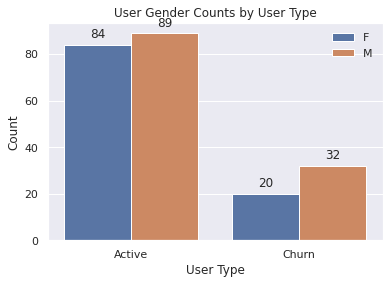

In [27]:
ax = sns.countplot(x="churn", hue="gender", data=data)
ax.legend().set_title("")

# Annotations
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.0,
        height + 3,
        "{:.0f}".format(height),
        ha="center",
    )
plt.title("User Gender Counts by User Type")
plt.xlabel("User Type")
plt.ylabel("Count");

## User Location

## Number of Songs Listened Per Session

## Average Song Length

## Page Visited 

The `page` column contains information on the page visited or functions used by each user.

In [28]:
action_list = df.select("page").distinct().toPandas().iloc[:,0]

Exam the statistics of each of the `page` visited by users and see if there is any difference trend between the `active` and `churned` users.

In [29]:
def get_user_page_count(page, alias, df=df):
    """Query and return the count of specific action by each user"""

    return (
        df.select("userId", "page")
        .filter("page = '{}'".format(page))
        .groupby("userId")
        .agg(F.expr("count(page)").alias(alias))
    )

In [31]:
# print the stats of the frequency of each page visited by two groups of user (churned vs active)

pages = df.select("page").distinct().rdd.flatMap(lambda x: x).collect()

for page in pages:
    page_df = get_user_page_count(page, page, df)
    churn_page = churn_df.join(page_df, on=["userId"],how='left').na.fill(0).toPandas()
    print(churn_page.iloc[:,1:].groupby("churn").describe().unstack().unstack())

churn             0     1
Cancel count  173.0  52.0
       mean     0.0   1.0
       std      0.0   0.0
       min      0.0   1.0
       25%      0.0   1.0
       50%      0.0   1.0
       75%      0.0   1.0
       max      0.0   1.0
churn                            0          1
Submit Downgrade count  173.000000  52.000000
                 mean     0.312139   0.173077
                 std      0.634037   0.382005
                 min      0.000000   0.000000
                 25%      0.000000   0.000000
                 50%      0.000000   0.000000
                 75%      0.000000   0.000000
                 max      3.000000   1.000000
churn                       0          1
Thumbs Down count  173.000000  52.000000
            mean    11.849711   9.538462
            std     14.035274   9.088803
            min      0.000000   0.000000
            25%      2.000000   2.000000
            50%      8.000000   7.000000
            75%     17.000000  15.250000
            max     75.0

**Observation**

The active user tend to have higher count on almost all the different pages visited except for the `Roll Advert` page than the churned users. This observation is expected because active users generally have longer user life time and higher unique sessions logged, thus they are likely to use all features and visited all pages on Sparkify in absolute counts when compared to that of the churned users.

We might be able to draw more insights from the `page` column if we look at the page count normalized in some way (i.e. per session or per day)

### Page Visited Normalized by Sessions

In [47]:
def get_page_count_per_session(page, df=df):
    """Query and return the count of specific page visited by each user per session"""

    session_count = get_session_count(df)
    page_count = get_user_page_count(page,page, df)
    output_df = session_count.join(page_count, on=["userId"], how="left").na.fill(0)
    output_df = output_df.withColumn(
        f"{page} Per Session", F.col(page) / F.col("num_unique_sessions")
    )

    return output_df.select(output_df.columns[0], output_df.columns[-1])

Print the descriptive stastics on the count of pages visited per session for churned and active users. 

In [49]:
# print the descriptiveof the frequency of each page visited by two groups of user (churned vs active)

pages = df.select("page").distinct().rdd.flatMap(lambda x: x).collect()

for page in pages:
    page_df = get_page_count_per_session(page, df)
    churn_page = churn_df.join(page_df, on=["userId"],how='left').na.fill(0).toPandas()
    print(churn_page.iloc[:,1:].groupby("churn").describe().unstack().unstack())

churn                         0          1
Cancel Per Session count  173.0  52.000000
                   mean     0.0   0.236115
                   std      0.0   0.294954
                   min      0.0   0.027027
                   25%      0.0   0.083333
                   50%      0.0   0.118056
                   75%      0.0   0.200000
                   max      0.0   1.000000
churn                                        0          1
Submit Downgrade Per Session count  173.000000  52.000000
                             mean     0.017383   0.015707
                             std      0.041817   0.038427
                             min      0.000000   0.000000
                             25%      0.000000   0.000000
                             50%      0.000000   0.000000
                             75%      0.000000   0.000000
                             max      0.333333   0.142857
churn                                   0          1
Thumbs Down Per Session count  173.000

### Visualization of Page Visited per Session

In [208]:
def page_distplot(page, df=df, churn_df=churn_df):
    """plot the distribution of specific number of actions per active vs. churned user """

    # Data preparation
    page_count = get_page_count_per_session(page, df)
    data = churn_df.join(page_count, on=["userId"]).toPandas()
    
    # Plot
    f, axes = plt.subplots(1,2, sharex=True,figsize=(12.8,4.8), dpi=120)
    sns.distplot(
        data[data["churn"] == 0][f"{page} Per Session"],
        kde=False,
        label="Active",
        ax=axes[0]
    )
    sns.distplot(
        data[data["churn"] == 1][f"{page} Per Session"],
        kde=False,
        label="Churned",
        ax=axes[0]
    )
    sns.distplot(
        data[data["churn"] == 0][f"{page} Per Session"],
        kde=True,
        label="Active",
        ax=axes[1]
    )
    sns.distplot(
        data[data["churn"] == 1][f"{page} Per Session"],
        kde=True,
        label="Churned",
        ax=axes[1]
    )
#     f.suptitle(f"Count of Page Visisted - {page} Per Session by Active vs. Churned Users")
    axes[0].set_title("Absolute Count")
    axes[1].set_title("Gaussian Kernel Density Estimate")
    axes[0].set_xlabel("")
    axes[1].set_xlabel("")
    axes[1].legend()
    f.text(0.5, 0.01, f"Average {page} per Session", ha='center') 
    return f,axes

/home/roger/anaconda3/envs/sparkify/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/roger/anaconda3/envs/sparkify/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


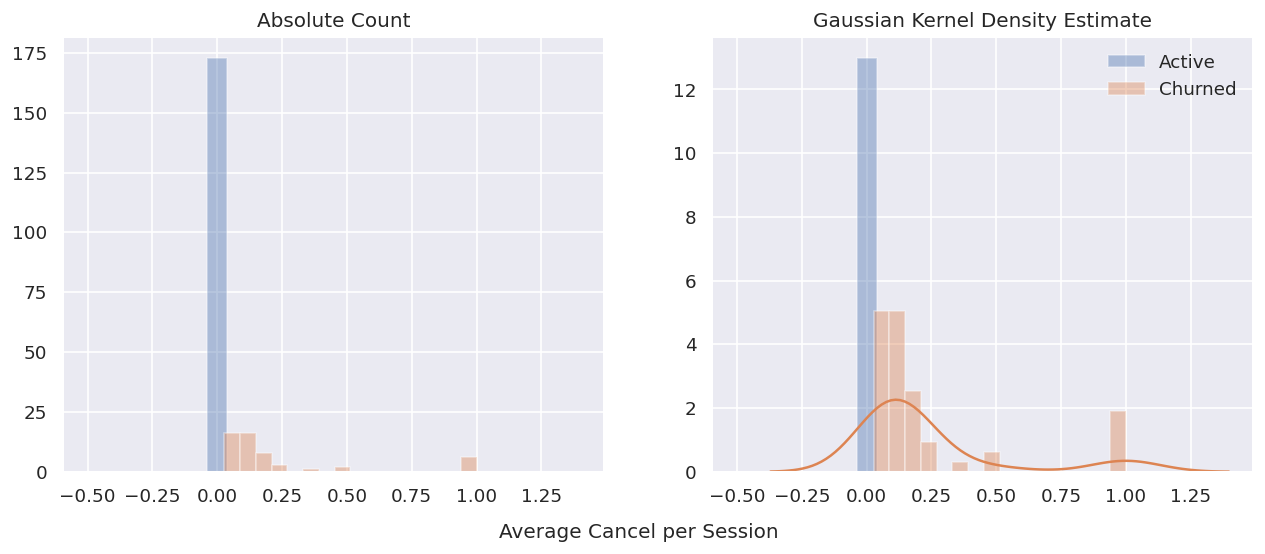

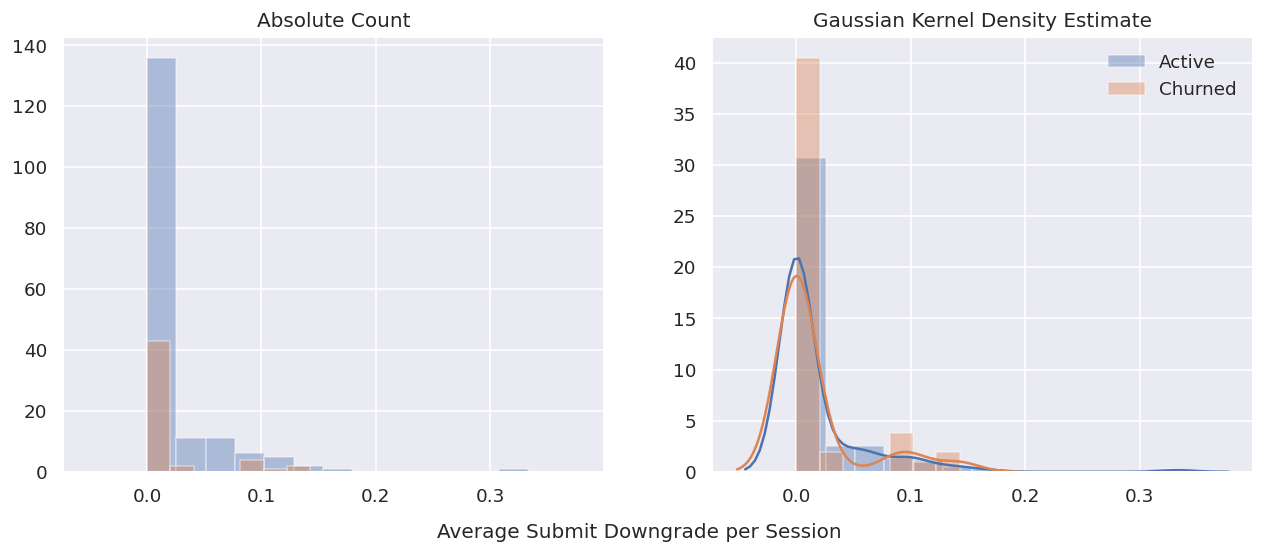

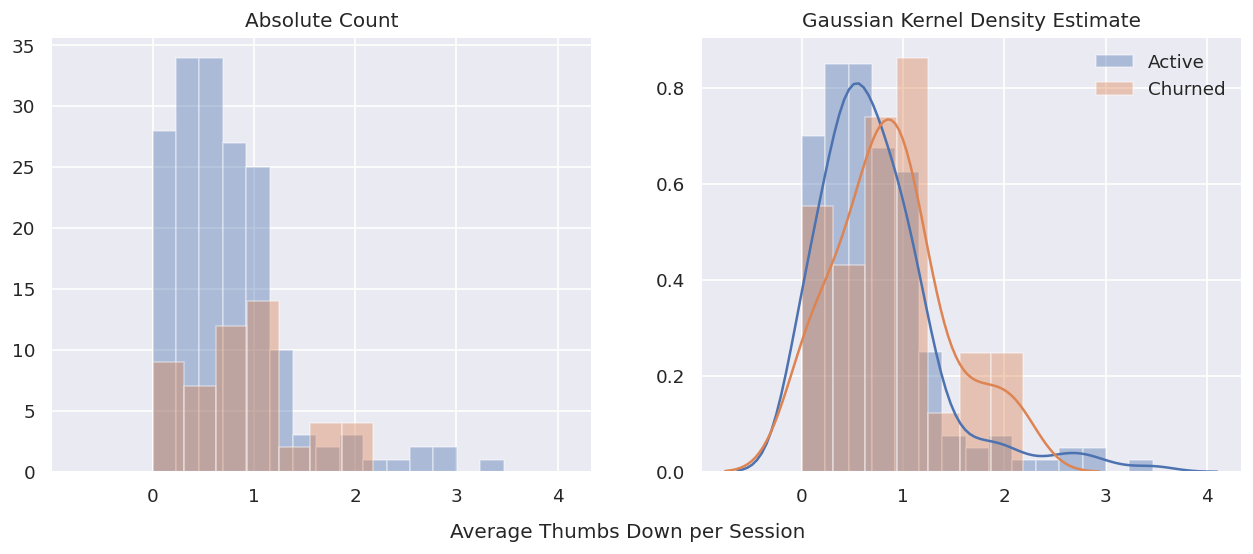

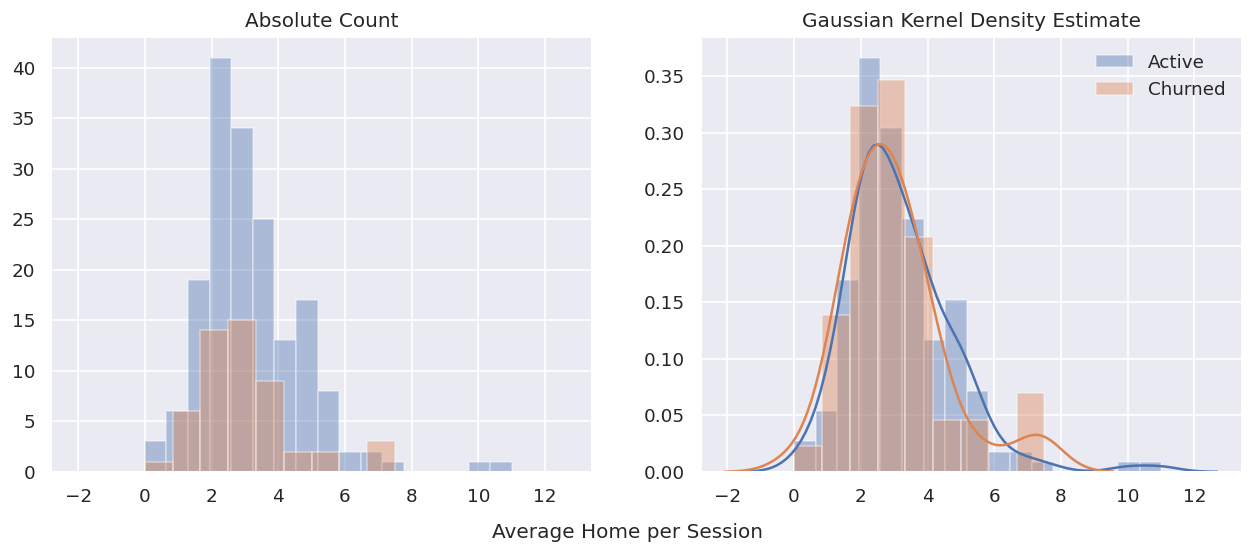

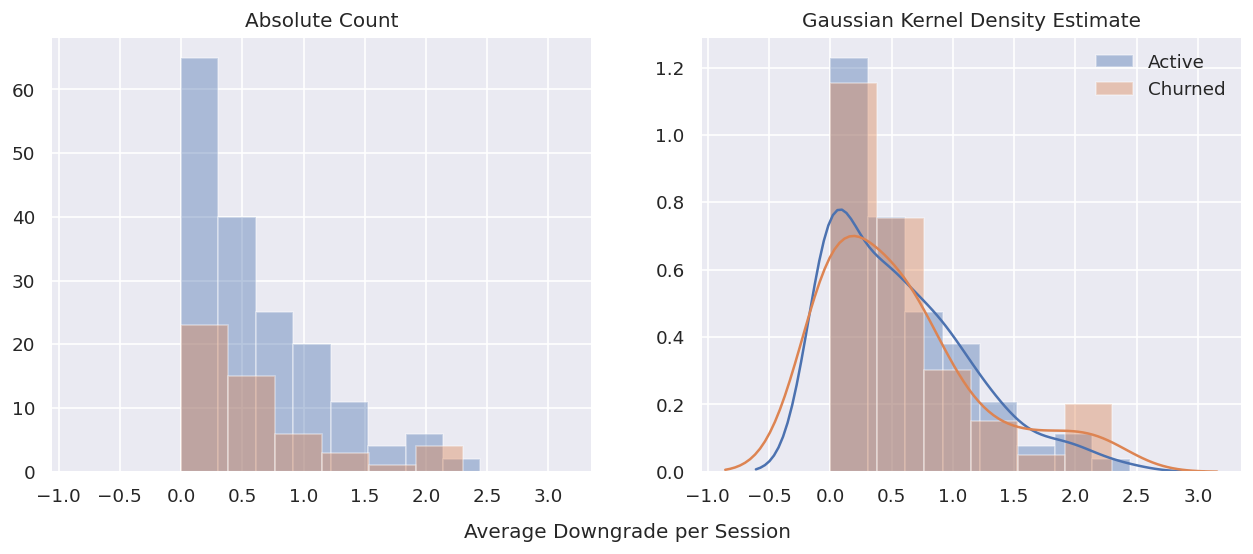

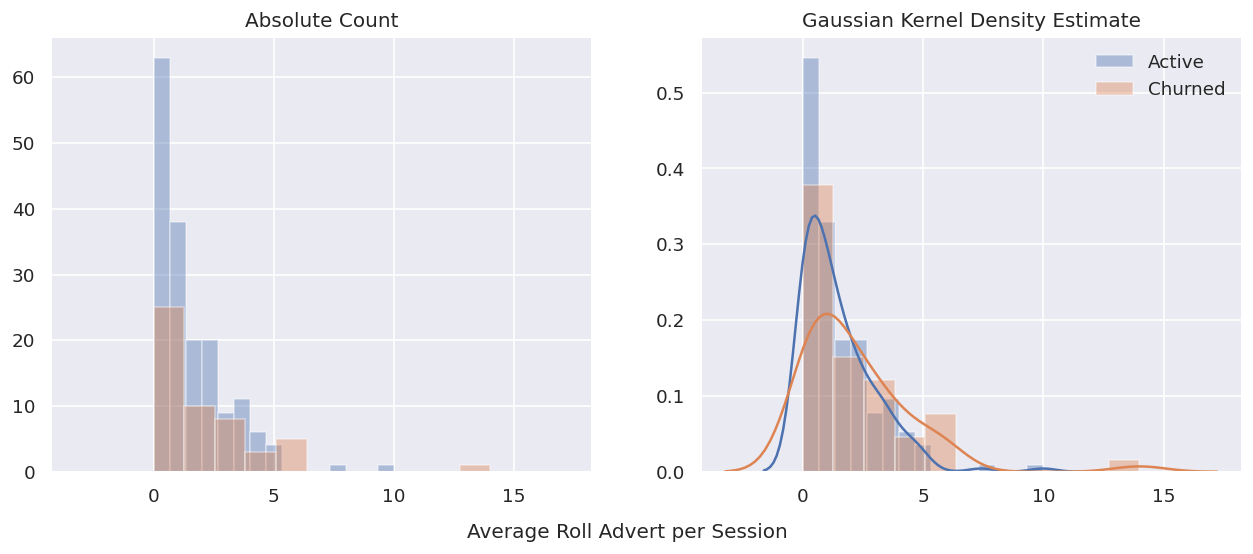

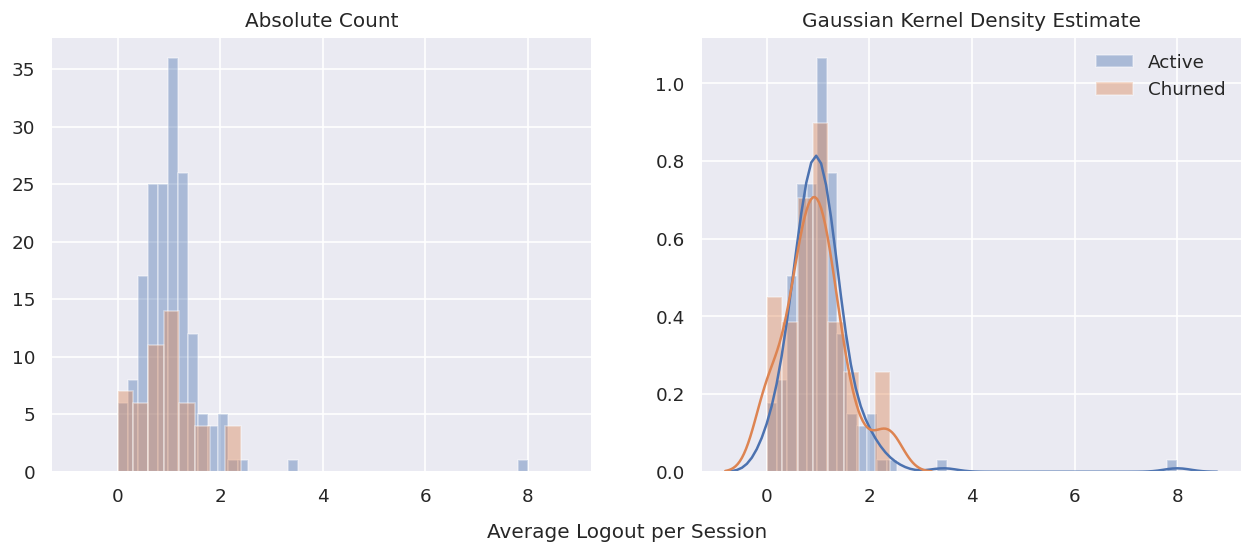

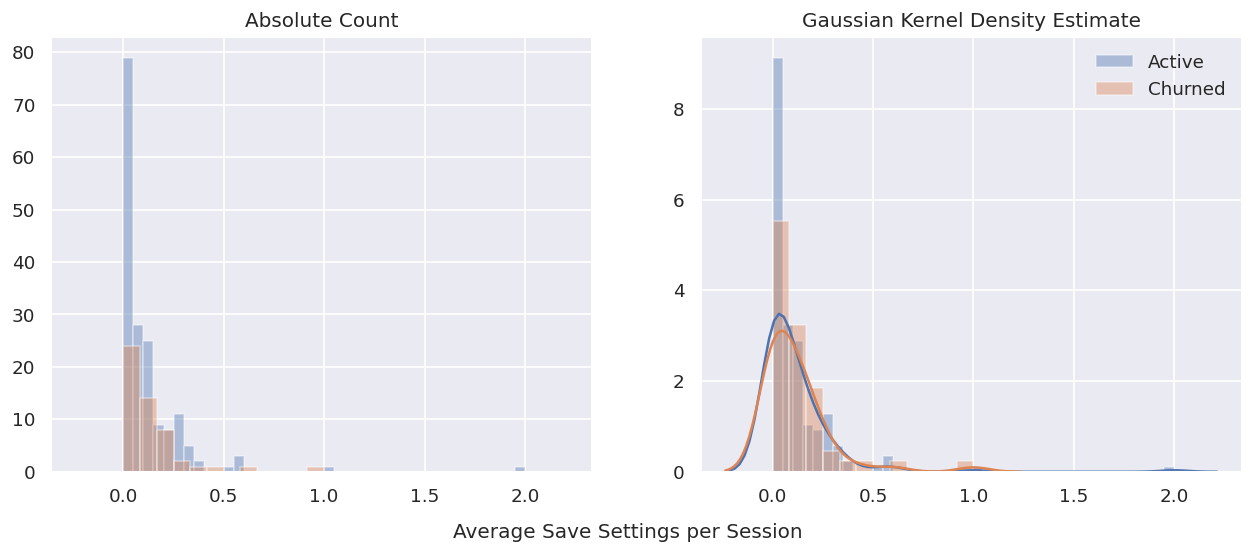

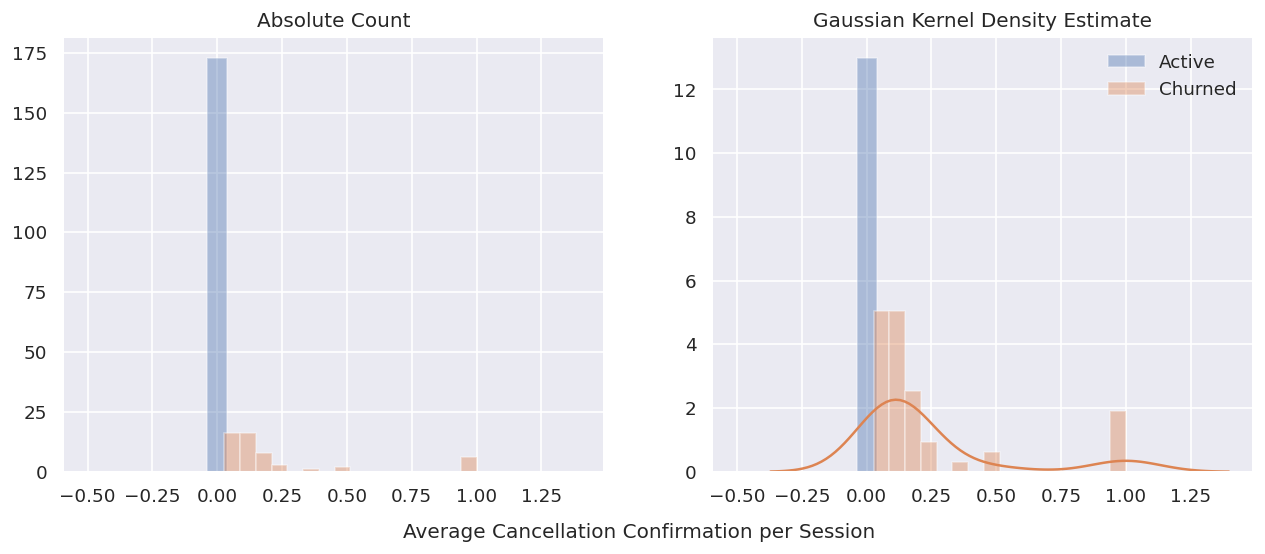

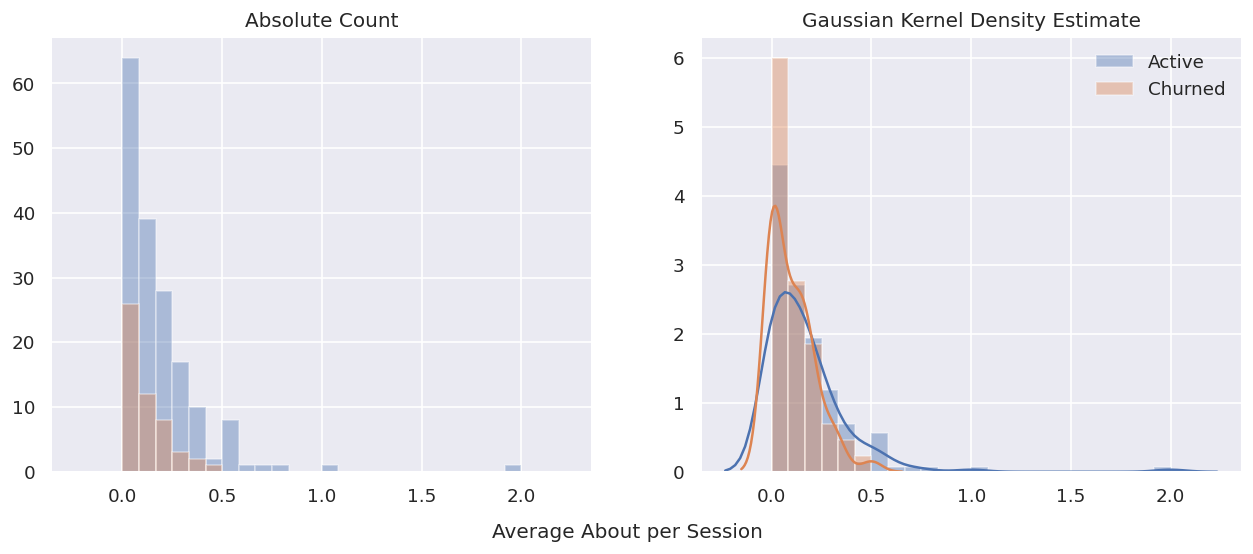

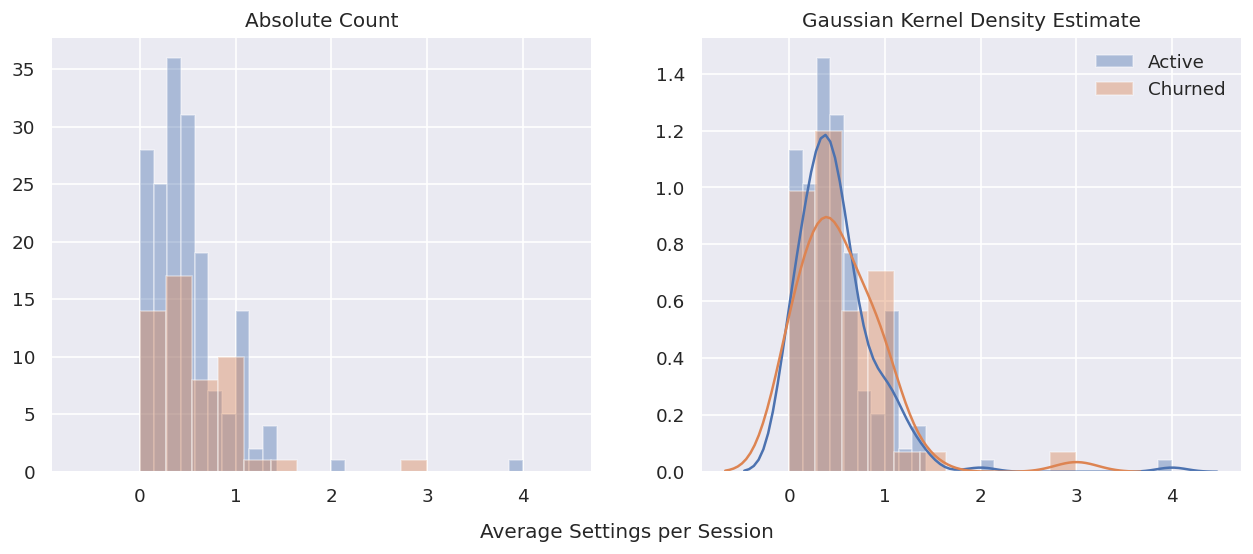

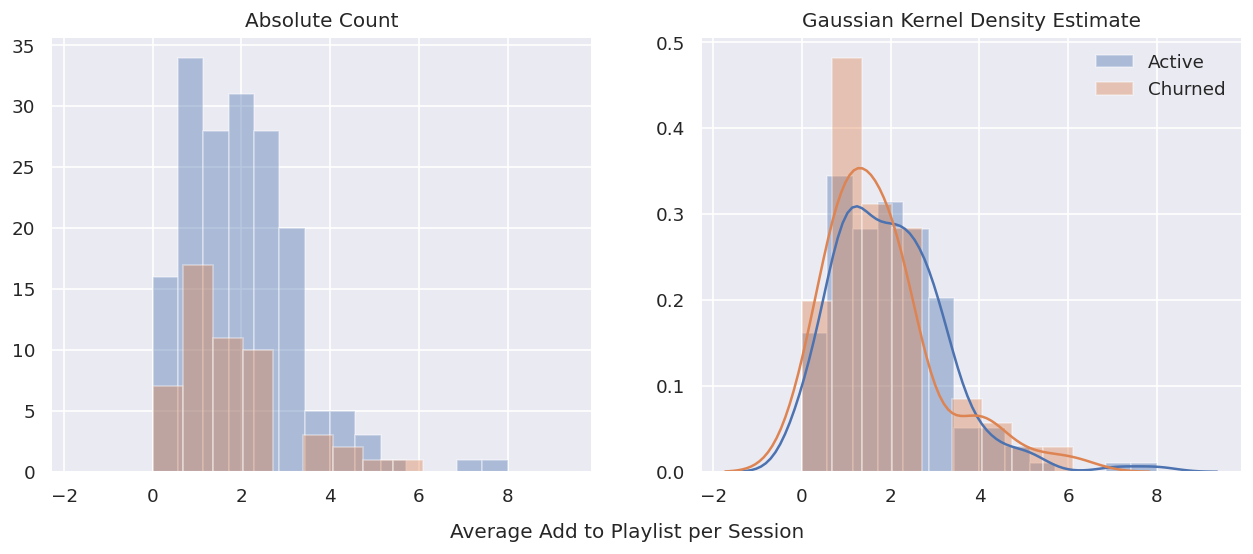

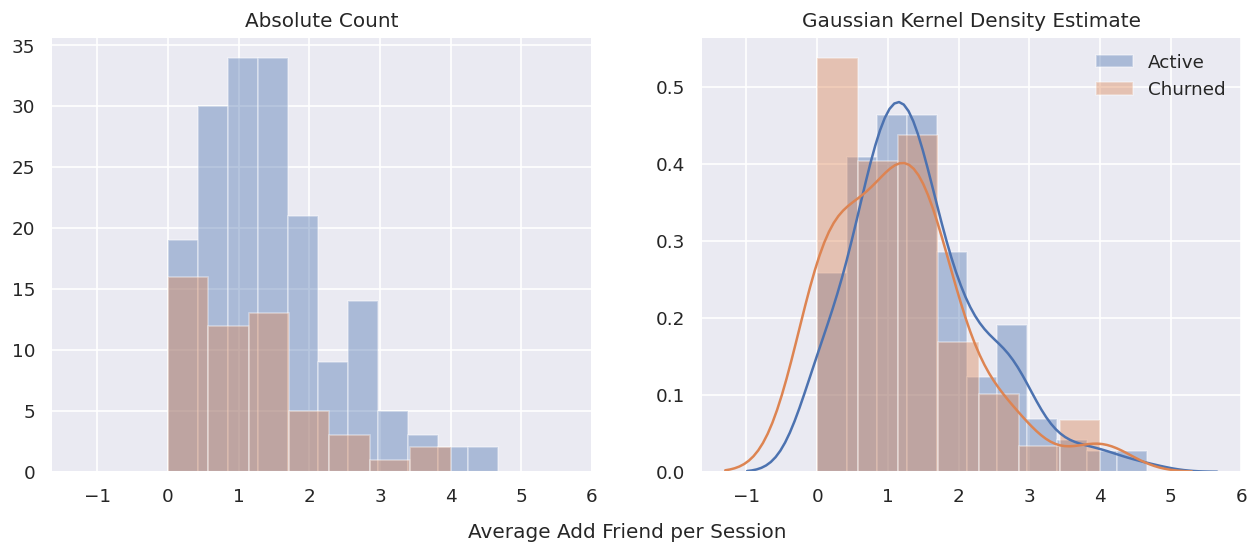

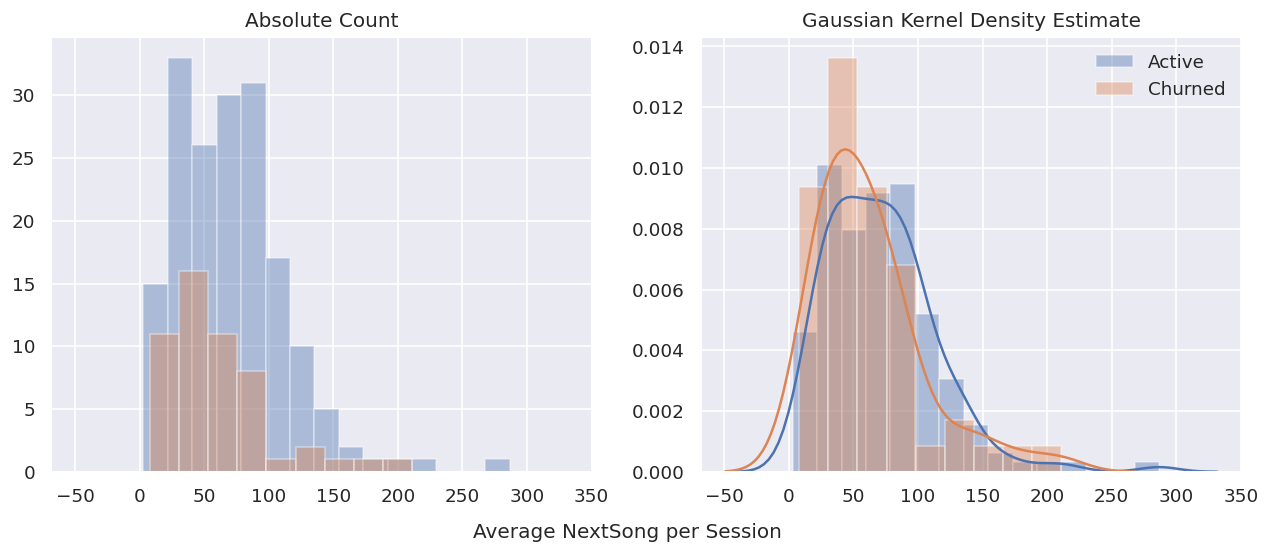

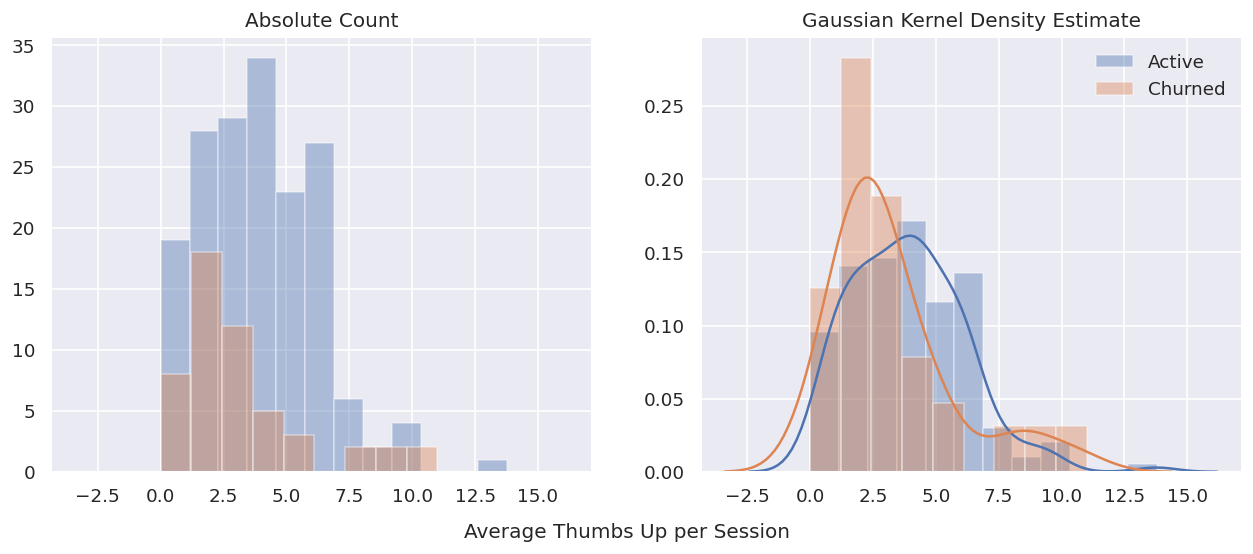

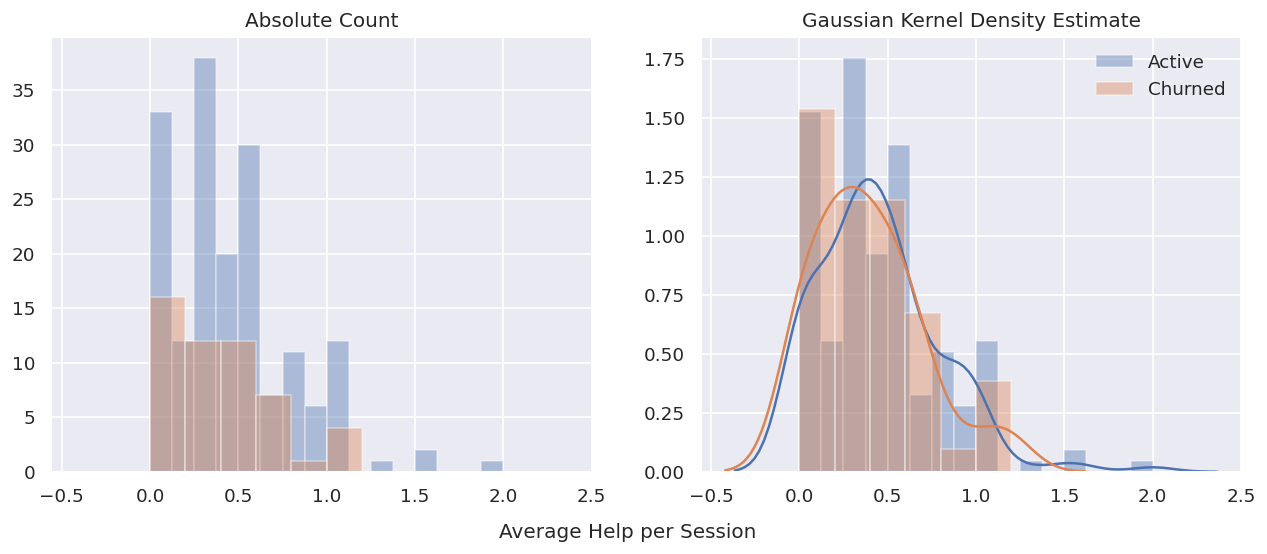

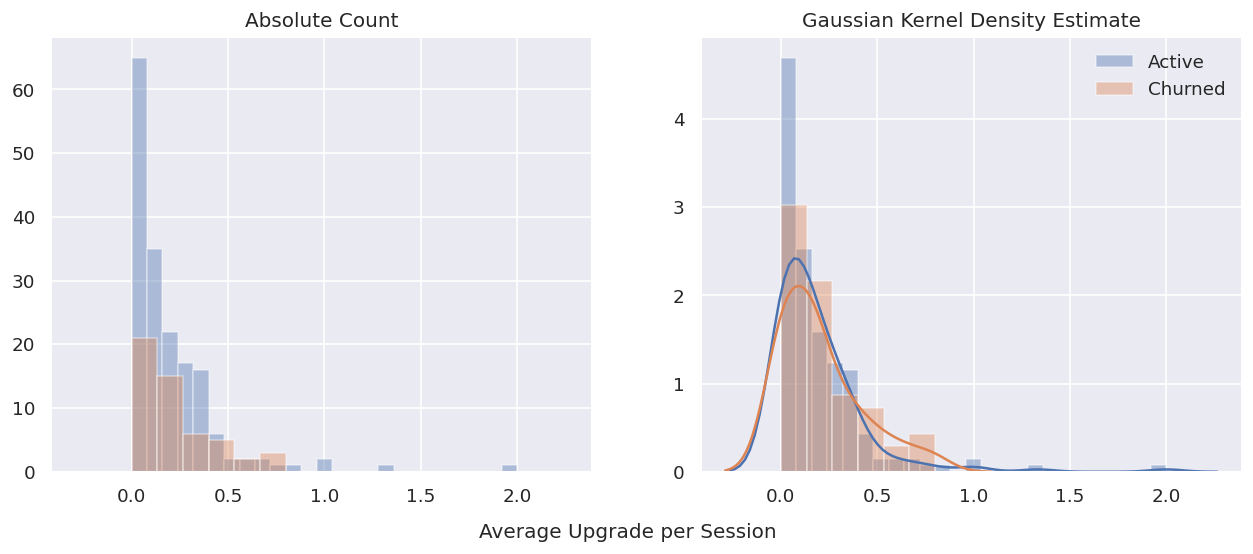

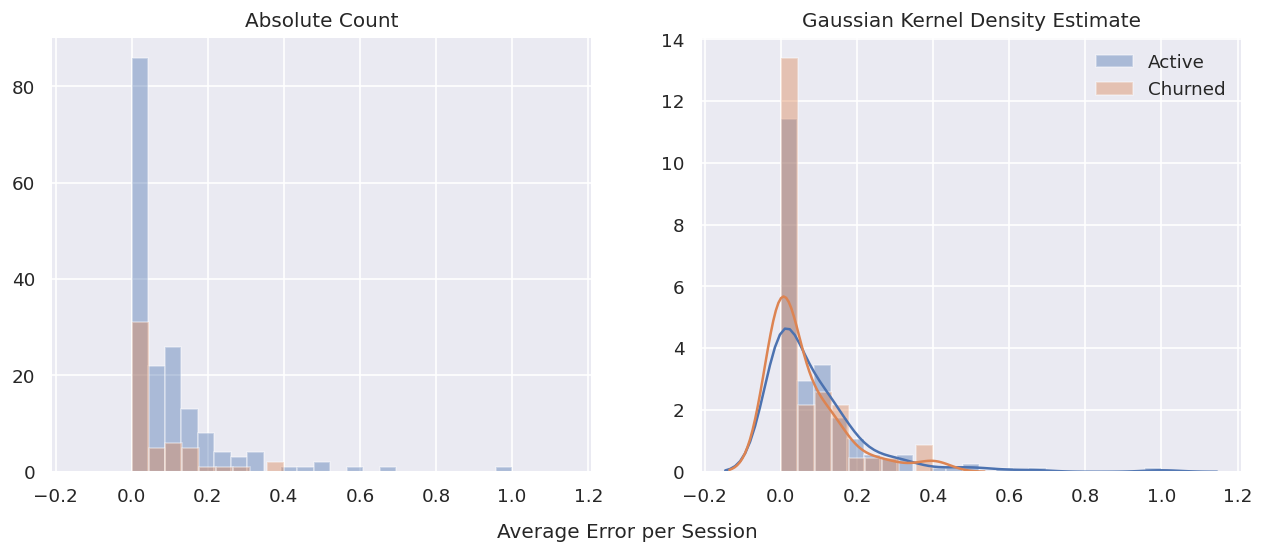

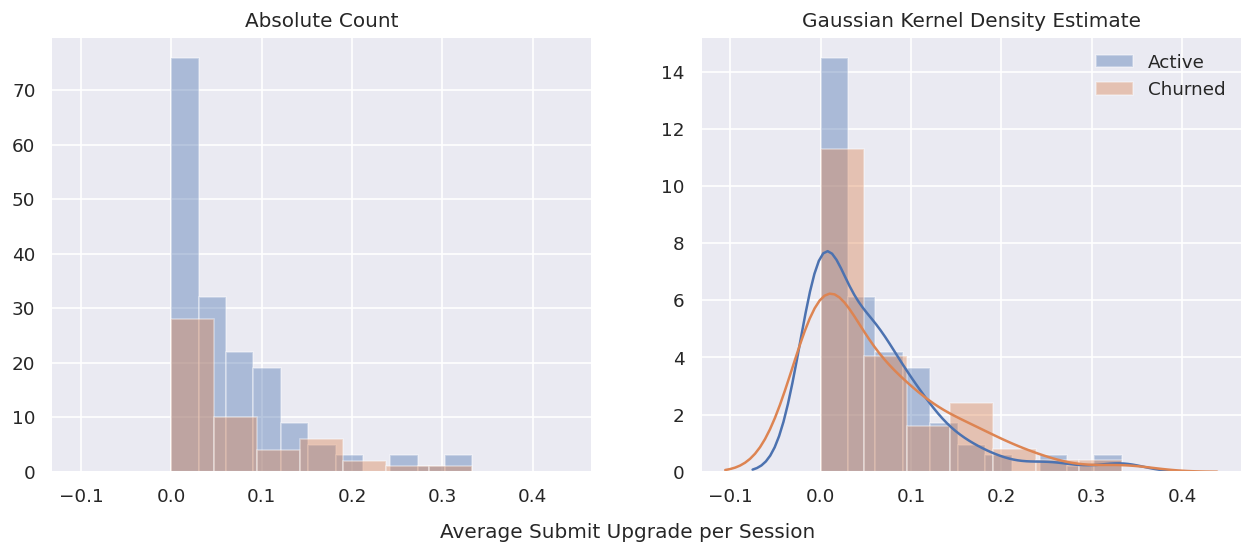

In [215]:
for page in pages:
    page_distplot(page);

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [ ]:
churn_df = get_churn(df)
user_life_df = get_days_since_reg(df)
session_df = get_session_count(df)
gender_df = get_gender(df)
page_df


In [380]:
pages

['Cancel',
 'Submit Downgrade',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'Cancellation Confirmation',
 'About',
 'Settings',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade']

In [384]:
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [393]:
df.select("userId","sessionId","length","song").filter(F.col("length").isNull()).show()

+------+---------+------+----+
|userId|sessionId|length|song|
+------+---------+------+----+
|    30|       29|  null|null|
|     9|        8|  null|null|
|     9|        8|  null|null|
|    54|       53|  null|null|
|    54|       53|  null|null|
|     9|        8|  null|null|
|     9|        8|  null|null|
|     9|        8|  null|null|
|    74|      217|  null|null|
|     9|        8|  null|null|
|    30|       29|  null|null|
|     4|      240|  null|null|
|     4|      240|  null|null|
|    74|      217|  null|null|
|     4|      240|  null|null|
|    74|      217|  null|null|
|     9|        8|  null|null|
|    30|       29|  null|null|
|    74|      217|  null|null|
|    30|       29|  null|null|
+------+---------+------+----+
only showing top 20 rows



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.